In [235]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from src.utils import eda
import time
import datetime

In [236]:
datos = pd.read_csv('/Users/cecy/Documents/MCD/IDS/Proyecto_1/incidentes-viales-c5.csv')

In [237]:
datos.shape

(1383138, 18)

In [238]:
datos.head()

,folio,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,año_cierre,mes_cierre,hora_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,geopoint,mes
0,GA/160123/05714,23/01/2016,22:35:04,Sábado,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,00:21:08,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,"19.422113,-99.084643",1
1,AO/160123/05826,23/01/2016,22:50:49,Sábado,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,04:40:37,CUAJIMALPA,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,"19.35832,-99.297641",1
2,C4/160124/02187,24/01/2016,09:40:11,Domingo,(N) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,11:13:03,TLALPAN,accidente-choque sin lesionados,19.217070,-99.219070,EMERGENCIA,LLAMADA DEL 066,TLALPAN,"19.21707,-99.21907008",1
3,C4/160124/05723,24/01/2016,22:40:57,Domingo,(N) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,22:55:51,MAGDALENA CONTRERAS,accidente-choque sin lesionados,19.320580,-99.241010,EMERGENCIA,LLAMADA DEL 066,MAGDALENA CONTRERAS,"19.32057999,-99.24100992",1
4,C4/160124/01334,24/01/2016,04:25:15,Domingo,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,05:03:59,MIGUEL HIDALGO,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,"19.45289997,-99.21587004",1


In [239]:
datos.dtypes

folio                 object
fecha_creacion        object
hora_creacion         object
dia_semana            object
codigo_cierre         object
fecha_cierre          object
año_cierre             int64
mes_cierre            object
hora_cierre           object
delegacion_inicio     object
incidente_c4          object
latitud              float64
longitud             float64
clas_con_f_alarma     object
tipo_entrada          object
delegacion_cierre     object
geopoint              object
mes                    int64
dtype: object

In [240]:
datos.nunique()

folio                1383138
fecha_creacion          2637
hora_creacion         105887
dia_semana                 7
codigo_cierre              5
fecha_cierre            2621
año_cierre                 7
mes_cierre                12
hora_cierre           106827
delegacion_inicio         16
incidente_c4              26
latitud                82501
longitud               78984
clas_con_f_alarma          4
tipo_entrada               9
delegacion_cierre         16
geopoint              134288
mes                       12
dtype: int64

In [241]:
# Convertir columna en datetime 
datos['fecha_creacion'] = pd.to_datetime(datos['fecha_creacion'], dayfirst = True) #, format='%Y-%m-%d')
datos['fecha_cierre'] = pd.to_datetime(datos['fecha_cierre'], dayfirst = True)#, format='%H:%M:%S')

### Corrigiendo `hora_creacion`

In [242]:
df_hrs_raras = datos.loc[~datos["hora_creacion"].str.contains(':', case = False, na = None)]

In [243]:
hrs_raras = df_hrs_raras['hora_creacion']

In [244]:
hrs_raras = hrs_raras.astype('float')
hours = [datetime.timedelta(days = float(num)) for num in hrs_raras]

In [245]:
data_hr_corregida = {'folio':df_hrs_raras['folio'],'hora_creacion':df_hrs_raras['hora_creacion'],'hora_creacion_corregida':hours}

In [246]:
dataframe_hrcorregida = pd.DataFrame(data = data_hr_corregida)

In [247]:
dataframe_hrcorregida = df_hrs_raras.copy()
dataframe_hrcorregida['hora_creacion_corregida'] = hours

In [248]:
# Eliminamos microsegundos
dataframe_hrcorregida['hora_creacion_corregida'] = dataframe_hrcorregida['hora_creacion_corregida'].dt.floor('s')

In [249]:
dataframe_hrcorregida['hora_creacion_corregida'] = dataframe_hrcorregida['hora_creacion_corregida'].astype(str)
dataframe_hrcorregida['hora_creacion_corregida'] = dataframe_hrcorregida['hora_creacion_corregida'].str.replace('0 days ', '')

In [250]:
dataframe_hrcorregida['hora_creacion'] = dataframe_hrcorregida['hora_creacion_corregida']

In [251]:
datos = datos.append(dataframe_hrcorregida)

In [252]:
datos.drop_duplicates(keep = 'last', subset = ['folio'], inplace = True)

### Corrigiendo `hora_cierre`

In [253]:
df_hrs_raras = datos.loc[~datos["hora_cierre"].str.contains(':', case = False, na = None)]

In [254]:
hrs_raras = df_hrs_raras['hora_cierre']

In [255]:
hrs_raras = hrs_raras.astype('float')
hours = [datetime.timedelta(days=float(num)) for num in hrs_raras]

In [256]:
data_hr_corregida = {'folio':df_hrs_raras['folio'],'hora_cierre':df_hrs_raras['hora_cierre'],'hora_cierre_corregida':hours}

In [257]:
dataframe_hrcorregida = pd.DataFrame(data = data_hr_corregida)

In [258]:
dataframe_hrcorregida = df_hrs_raras.copy()
dataframe_hrcorregida['hora_cierre_corregida'] = hours

In [259]:
# Eliminamos microsegundos
dataframe_hrcorregida['hora_cierre_corregida'] = dataframe_hrcorregida['hora_cierre_corregida'].dt.floor('s')

In [260]:
dataframe_hrcorregida['hora_cierre_corregida'] = dataframe_hrcorregida['hora_cierre_corregida'].astype(str)
dataframe_hrcorregida['hora_cierre_corregida'] = dataframe_hrcorregida['hora_cierre_corregida'].str.replace('0 days ', '')

In [261]:
dataframe_hrcorregida['hora_cierre'] = dataframe_hrcorregida['hora_cierre_corregida']

In [262]:
datos = datos.append(dataframe_hrcorregida)

In [263]:
datos.drop_duplicates(keep = 'last', subset = ['folio'], inplace = True)

In [264]:
datos['hora_creacion'] = pd.to_datetime(datos['hora_creacion'], format = '%H:%M:%S')
datos['hora_cierre'] = pd.to_datetime(datos['hora_cierre'], format = '%H:%M:%S')

In [265]:
datos.drop(columns = 'hora_creacion_corregida', inplace = True)
datos.drop(columns = 'hora_cierre_corregida', inplace = True)

In [266]:
datos = datos.astype({"dia_semana":'category',
                                "año_cierre":'category', 
                                "codigo_cierre":'category', 
                                "mes_cierre":'category',
                                "delegacion_inicio":'category', 
                                "incidente_c4":'category' , 
                                "clas_con_f_alarma":'category', 
                                "tipo_entrada":'category',  
                                "delegacion_cierre":'category',
                                "mes":'category'}) 

In [267]:
datos.head()

,folio,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,año_cierre,mes_cierre,hora_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,geopoint,mes
0,GA/160123/05714,2016-01-23,1900-01-01 22:35:04,Sábado,(A) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,1900-01-01 00:21:08,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,"19.422113,-99.084643",1
1,AO/160123/05826,2016-01-23,1900-01-01 22:50:49,Sábado,(A) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,1900-01-01 04:40:37,CUAJIMALPA,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,"19.35832,-99.297641",1
2,C4/160124/02187,2016-01-24,1900-01-01 09:40:11,Domingo,(N) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,1900-01-01 11:13:03,TLALPAN,accidente-choque sin lesionados,19.217070,-99.219070,EMERGENCIA,LLAMADA DEL 066,TLALPAN,"19.21707,-99.21907008",1
3,C4/160124/05723,2016-01-24,1900-01-01 22:40:57,Domingo,(N) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,1900-01-01 22:55:51,MAGDALENA CONTRERAS,accidente-choque sin lesionados,19.320580,-99.241010,EMERGENCIA,LLAMADA DEL 066,MAGDALENA CONTRERAS,"19.32057999,-99.24100992",1
4,C4/160124/01334,2016-01-24,1900-01-01 04:25:15,Domingo,(A) La unidad de atención a emergencias fue de...,2016-01-24,2016,Enero,1900-01-01 05:03:59,MIGUEL HIDALGO,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,"19.45289997,-99.21587004",1


In [268]:
datos.dtypes

folio                        object
fecha_creacion       datetime64[ns]
hora_creacion        datetime64[ns]
dia_semana                 category
codigo_cierre              category
fecha_cierre         datetime64[ns]
año_cierre                 category
mes_cierre                 category
hora_cierre          datetime64[ns]
delegacion_inicio          category
incidente_c4               category
latitud                     float64
longitud                    float64
clas_con_f_alarma          category
tipo_entrada               category
delegacion_cierre          category
geopoint                     object
mes                        category
dtype: object

In [269]:
profiling_numericas,profiling_categoricas,profiling_texto = eda.genera_profiling_por_variable(datos)

In [270]:
profiling_numericas

,metrica,latitud,longitud
0,tipo,float64,float64
1,numero de observaciones,1.3827e+06,1.3827e+06
2,media,19.38,-99.14
3,desviacion estándar,0.27,2.4
4,cuartil 25%,19.34,-99.18
5,cuartil 50%,19.38,-99.14
6,cuartil 75%,19.43,-99.1
7,minimo,19.09,-991.76
8,maximo,195.3,-98.95
9,numero de observaciones unicas,82501,78984


In [271]:
profiling_categoricas

,metrica,dia_semana,codigo_cierre,año_cierre,mes_cierre,delegacion_inicio,incidente_c4,clas_con_f_alarma,tipo_entrada,delegacion_cierre,mes
0,tipo,category,category,category,category,category,category,category,category,category,category
1,numero de categorias,7,5,7,12,16,26,4,9,16,12
2,numero de observaciones,1383138,1383138,1383138,1383138,1383138,1383138,1383138,1383138,1383138,1383138
3,observaciones nulas,0,0,0,0,158,0,0,0,140,0
4,% observaciones nulas,0,0,0,0,0.000114233,0,0,0,0.000101219,0
5,valores unicos,"[Sábado, Domingo, Lunes, Martes, Miércoles, Ju...",[(A) La unidad de atención a emergencias fue d...,"[2016, 2017, 2018, 2019, 2015, 2014, 2020]","[Enero, Febrero, Marzo, Septiembre, Octubre, M...","[VENUSTIANO CARRANZA, CUAJIMALPA, TLALPAN, MAG...","[accidente-choque sin lesionados, accidente-ch...","[EMERGENCIA, URGENCIAS MEDICAS, FALSA ALARMA, ...","[BOTÓN DE AUXILIO, LLAMADA DEL 066, RADIO, CÁM...","[VENUSTIANO CARRANZA, CUAJIMALPA, TLALPAN, MAG...","[1, 2, 3, 9, 10, 5, 6, 4, 8, 12, 7, 11]"
6,moda1/veces/porcentaje,"[Viernes, 229,681, 16.61%]",[(A) La unidad de atención a emergencias fue d...,"[2018, 246,577, 17.83%]","[Octubre, 133,641, 9.66%]","[IZTAPALAPA, 223,687, 16.17%]","[accidente-choque sin lesionados, 760,506, 54....","[EMERGENCIA, 799,037, 57.77%]","[LLAMADA DEL 911, 739,339, 53.45%]","[IZTAPALAPA, 225,202, 16.28%]","[10, 133,641, 9.66%]"
7,moda2/veces/porcentaje,"[Sábado, 214,134, 15.48%]",[(D) El incidente reportado se registró en dos...,"[2019, 229,467, 16.59%]","[Agosto, 121,123, 8.76%]","[GUSTAVO A. MADERO, 144,620, 10.46%]","[accidente-choque con lesionados, 315,031, 22....","[URGENCIAS MEDICAS, 572,619, 41.4%]","[LLAMADA DEL 066, 463,432, 33.51%]","[GUSTAVO A. MADERO, 147,582, 10.67%]","[8, 121,123, 8.76%]"
8,moda3/veces/porcentaje,"[Jueves, 198,147, 14.33%]",[(N) La unidad de atención a emergencias fue d...,"[2017, 226,535, 16.38%]","[Septiembre, 120,581, 8.72%]","[CUAUHTEMOC, 141,391, 10.22%]","[lesionado-atropellado, 193,553, 13.99%]","[FALSA ALARMA, 10,630, 0.77%]","[BOTÓN DE AUXILIO, 78,630, 5.68%]","[CUAUHTEMOC, 141,781, 10.25%]","[9, 120,581, 8.72%]"


In [272]:
profiling_texto

,metrica,folio,geopoint
0,tipo,object,object
1,numero de observaciones,1383138,1383138
2,observaciones unicas,1383138,134288
3,% observaciones unicas,1,0.0970894
4,tamano promedio,15,22.4991
5,tamano minmo,15,14
6,tamano maximo,15,24


In [273]:
eda.CreaTablaConteoPorcentaje(datos,"tipo_entrada", False)

,tipo_entrada,porcentaje
LLAMADA DEL 911,"739,339",53.45%
LLAMADA DEL 066,"463,432",33.51%
BOTÓN DE AUXILIO,"78,630",5.68%
RADIO,"77,749",5.62%
LLAMADA APP911,"9,483",0.69%
ZELLO,"6,451",0.47%
REDES,"4,697",0.34%
CÁMARA,"3,276",0.24%
APLICATIVOS,81,0.01%


In [274]:
eda.CreaTablaConteoPorcentaje(datos,"incidente_c4", False)

,incidente_c4,porcentaje
accidente-choque sin lesionados,"760,506",54.98%
accidente-choque con lesionados,"315,031",22.78%
lesionado-atropellado,"193,553",13.99%
accidente-motociclista,"55,646",4.02%
accidente-volcadura,"31,766",2.3%
lesionado-accidente automovilístico,"6,054",0.44%
accidente-persona atrapada / desbarrancada,"5,607",0.41%
accidente-ciclista,"2,718",0.2%
accidente-otros,"2,465",0.18%
accidente-choque con prensados,"2,334",0.17%


In [275]:
eda.CreaTablaConteoPorcentaje(datos,"delegacion_inicio", False)

,delegacion_inicio,porcentaje
IZTAPALAPA,"223,687",16.17%
GUSTAVO A. MADERO,"144,620",10.46%
CUAUHTEMOC,"141,391",10.22%
MIGUEL HIDALGO,"115,864",8.38%
COYOACAN,"110,146",7.96%
BENITO JUAREZ,"104,322",7.54%
ALVARO OBREGON,"102,071",7.38%
VENUSTIANO CARRANZA,"94,393",6.82%
TLALPAN,"87,339",6.31%
AZCAPOTZALCO,"60,823",4.4%


In [276]:
eda.CreaTablaConteoPorcentaje(datos,"codigo_cierre", False)

,codigo_cierre,porcentaje
"(A) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos y confirmó la emergencia reportada","600,108",43.39%
"(D) El incidente reportado se registró en dos o más ocasiones procediendo a mantener un único reporte (afirmativo, informativo, negativo o falso) como el identificador para el incidente","495,631",35.83%
"(N) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos, pero en el sitio del evento nadie solicitó el apoyo de la unidad","271,677",19.64%
"(F) El operador/a o despachador/a identifican, antes de dar respuesta a la emergencia, que ésta es falsa. O al ser despachada una unidad de atención a emergencias en el lugar de los hechos se percatan que el incidente no corresponde al reportado inicialmente","10,626",0.77%
(I) El incidente reportado es afirmativo y se añade información adicional al evento,"5,096",0.37%


In [277]:
eda.CreaTablaConteoPorcentaje(datos,"clas_con_f_alarma", False)

,clas_con_f_alarma,porcentaje
EMERGENCIA,"799,037",57.77%
URGENCIAS MEDICAS,"572,619",41.4%
FALSA ALARMA,"10,630",0.77%
DELITO,852,0.06%


In [278]:
eda.CreaTablaConteoPorcentaje(datos,"dia_semana", False)

,dia_semana,porcentaje
Viernes,"229,681",16.61%
Sábado,"214,134",15.48%
Jueves,"198,147",14.33%
Miércoles,"193,857",14.02%
Martes,"189,669",13.71%
Lunes,"182,448",13.19%
Domingo,"175,202",12.67%


## Generando etiqueta

In [279]:
def generate_label(data):
    data['label'] = data['codigo_cierre'].str.split(' ', n = 1, expand = False)
    data['label'] = data['label'].apply(lambda x: x[0][1])
    data['label'] = data['label'].apply(lambda x: 1 if x == 'F' or x == 'N' else 0)

In [280]:
generate_label(datos)

In [281]:
datos.columns

Index(['folio', 'fecha_creacion', 'hora_creacion', 'dia_semana',
       'codigo_cierre', 'fecha_cierre', 'año_cierre', 'mes_cierre',
       'hora_cierre', 'delegacion_inicio', 'incidente_c4', 'latitud',
       'longitud', 'clas_con_f_alarma', 'tipo_entrada', 'delegacion_cierre',
       'geopoint', 'mes', 'label'],
      dtype='object')

In [282]:
df = datos.copy()

In [283]:
df = datos.astype({"dia_semana":'str',
                                "año_cierre":'str', 
                                "codigo_cierre":'str', 
                                "mes_cierre":'str',
                                "delegacion_inicio":'str', 
                                "incidente_c4":'str' , 
                                "clas_con_f_alarma":'str', 
                                "tipo_entrada":'str',  
                                "delegacion_cierre":'str',
                                "mes":'str'}) 

(A) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos y confirmó la emergencia reportada

(D) El incidente reportado se registró en dos o más ocasiones procediendo a mantener un único reporte (afirmativo, informativo, negativo o falso) como el identificador para el incidente

(N) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos, pero en el sitio del evento nadie solicitó el apoyo de la unidad

(F) El operador/a o despachador/a identifican, antes de dar respuesta a la emergencia, que ésta es falsa. O al ser despachada una unidad de atención a emergencias en el lugar de los hechos se percatan que el incidente no corresponde al reportado inicialmente

(I) El incidente reportado es afirmativo y se añade información adicional al evento

In [284]:
def number_formatter_i(number, pos = None):
    """Convert a number into a human readable format."""
    magnitude = 0
    while abs(number) >= 1000:
        magnitude += 1
        number /= 1000
    return '%d%s' % (number, ['', 'K', 'M', 'B', 'T', 'Q'][magnitude])

In [285]:
def number_formatter_f(number, pos = None):
    """Convert a number into a human readable format."""
    magnitude = 0
    while abs(number) >= 1000:
        magnitude += 1
        number /= 1000
    return '%.1f%s' % (number, ['', 'K', 'M', 'B', 'T', 'Q'][magnitude])

## Definiendo opciones y variables a usar en gráficas

In [320]:
cod_order = ["(A)", "(D)", "(N)", "(F)", "(I)"]
cod_colors = ["seagreen", "lightsteelblue", "tomato", "darkred", "dodgerblue"]
cod_Palette = sns.set_palette(sns.color_palette(cod_colors))

In [287]:
label_order = [0, 1]
label_colors = ["seagreen", "indianred"]
label_Palette = sns.set_palette(sns.color_palette(label_colors))

In [288]:
dia_orden = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]
mes_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]
anio_orden = ["2014", "2015", "2016", "2017", "2018", "2019", "2020"]
del_orden = ['IZTAPALAPA', 'CUAUHTEMOC', 'GUSTAVO A. MADERO', 'MIGUEL HIDALGO',
       'BENITO JUAREZ', 'COYOACAN', 'VENUSTIANO CARRANZA', 'ALVARO OBREGON',
       'TLALPAN', 'AZCAPOTZALCO', 'IZTACALCO', 'XOCHIMILCO', 'TLAHUAC',
       'CUAJIMALPA', 'MAGDALENA CONTRERAS', 'MILPA ALTA']

# CÓDIGOS DE CIERRE

## Frecuencia códigos de cierre

In [289]:
codigos_cierre = pd.DataFrame(df['codigo_cierre'].value_counts())
codigos_cierre = codigos_cierre.rename(columns = {'codigo_cierre':'counts'})
codigos_cierre

,counts
"(A) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos y confirmó la emergencia reportada",600108
"(D) El incidente reportado se registró en dos o más ocasiones procediendo a mantener un único reporte (afirmativo, informativo, negativo o falso) como el identificador para el incidente",495631
"(N) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos, pero en el sitio del evento nadie solicitó el apoyo de la unidad",271677
"(F) El operador/a o despachador/a identifican, antes de dar respuesta a la emergencia, que ésta es falsa. O al ser despachada una unidad de atención a emergencias en el lugar de los hechos se percatan que el incidente no corresponde al reportado inicialmente",10626
(I) El incidente reportado es afirmativo y se añade información adicional al evento,5096


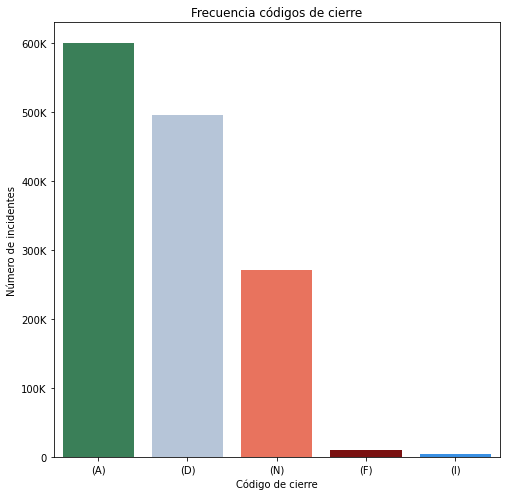

In [321]:
cod_labels = ("(A)", "(D)", "(N)", "(F)", "(I)")
y_pos = np.arange(len(cod_labels))

plt.figure(figsize = (8,8))
ax = sns.barplot(x = codigos_cierre.index, y = 'counts', data = codigos_cierre, palette = cod_Palette)
ax.set(title = 'Frecuencia códigos de cierre', xlabel = 'Código de cierre', ylabel = 'Número de incidentes')
plt.xticks(np.arange(len(cod_labels)), cod_labels)
ax.yaxis.set_major_formatter(FuncFormatter(number_formatter_i))
plt.show()

# ETIQUETA

In [291]:
label_del = df.groupby(['label','delegacion_inicio'], as_index = False).size()
label_dia = df.groupby(['label','dia_semana'], as_index = False).size()
label_mes = df.groupby(['label','mes_cierre'], as_index = False).size()
label_anio = df.groupby(['label','año_cierre'], as_index = False).size()
label_hora = df.groupby(['label','hora_creacion'], as_index = False).size()

In [292]:
label_total = pd.DataFrame(df['label'].value_counts())
label_total = label_total.rename(columns = {'label':'counts'})

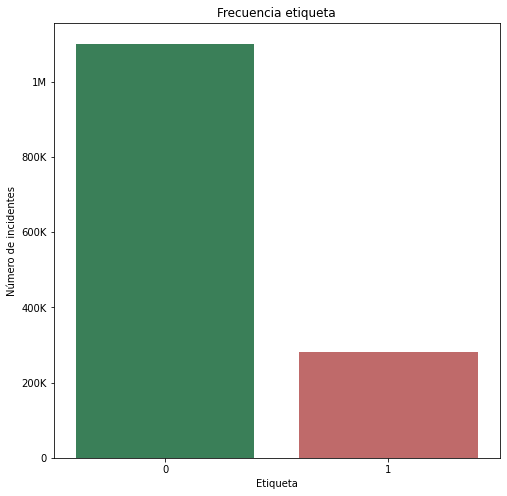

In [293]:
plt.figure(figsize = (8,8))
ax = sns.barplot(x = label_total.index, 
                 y = 'counts', 
                 data = label_total, 
                 palette = label_Palette)
ax.set(title = 'Frecuencia etiqueta', xlabel = 'Etiqueta', ylabel = 'Número de incidentes')
ax.yaxis.set_major_formatter(FuncFormatter(number_formatter_i))
plt.show()

## Etiqueta por Delegación

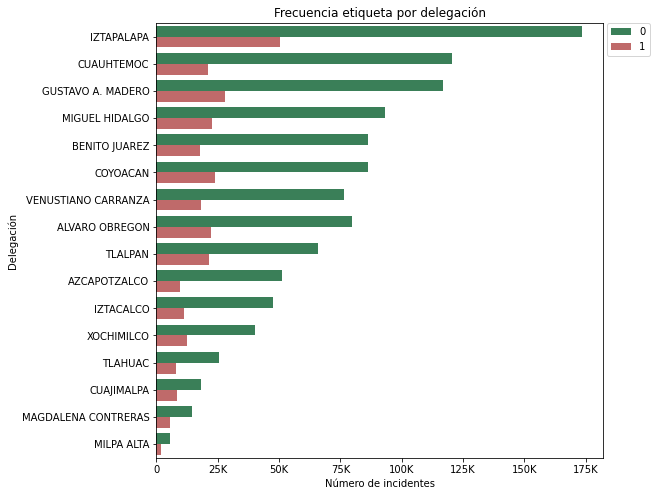

In [294]:
plt.figure(figsize = (8,8)) 
ax = sns.barplot(y = "delegacion_inicio", 
                 x = "size", 
                 data = label_del, 
                 hue = "label", 
                 order = del_orden,
                 palette = label_colors)
ax.set(title = 'Frecuencia etiqueta por delegación', xlabel = 'Número de incidentes', ylabel = 'Delegación')
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter_i))
ax.legend(bbox_to_anchor = (1.01, 1), loc = 'upper left', borderaxespad = 0)
plt.show()

## Etiqueta por día

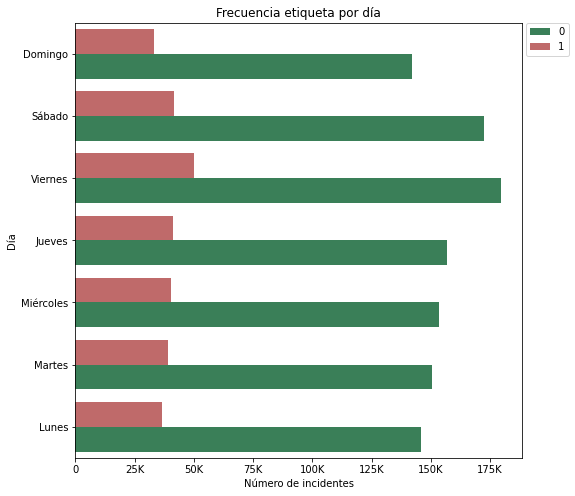

In [295]:
plt.figure(figsize = (8,8)) 
ax = sns.barplot(y = "dia_semana", 
                 x = "size", 
                 data = label_dia, 
                 hue = "label", 
                 order = dia_orden,
                 palette = label_colors)
ax.set(title = 'Frecuencia etiqueta por día', xlabel = 'Número de incidentes', ylabel = 'Día')
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter_i))
ax.set_ylim(ax.get_ylim()[::-1])
ax.legend(bbox_to_anchor = (1.01, 1), loc = 'upper left', borderaxespad = 0)
plt.show()

## Etiqueta por mes

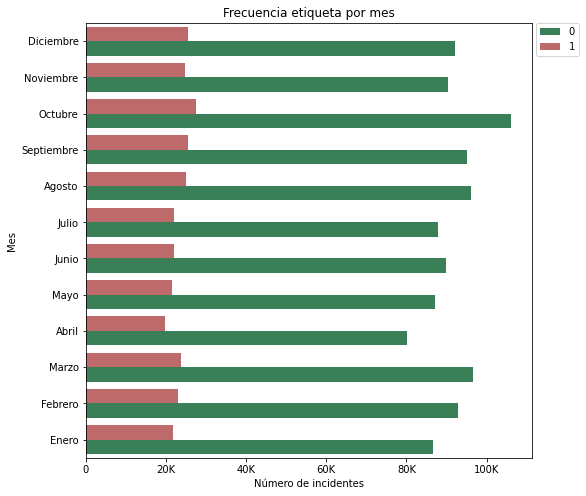

In [296]:
plt.figure(figsize = (8,8)) 
ax = sns.barplot(y = "mes_cierre", 
                 x = "size", 
                 data = label_mes, 
                 hue = "label", 
                 order = mes_orden,
                 palette = label_colors)
ax.set(title = 'Frecuencia etiqueta por mes', xlabel = 'Número de incidentes', ylabel = 'Mes')
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter_i))
ax.set_ylim(ax.get_ylim()[::-1])
ax.legend(bbox_to_anchor = (1.01, 1), loc = 'upper left', borderaxespad = 0)
plt.show()

## Etiqueta por año

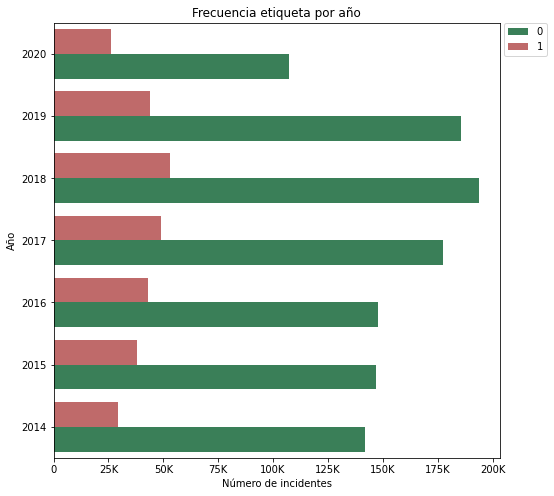

In [297]:
plt.figure(figsize = (8,8)) 
ax = sns.barplot(y = "año_cierre", 
                 x = "size", 
                 data = label_anio, 
                 hue = "label", 
                 order = anio_orden,
                 palette = label_colors)
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter_i))
ax.set_ylim(ax.get_ylim()[::-1])
ax.set(title = 'Frecuencia etiqueta por año', xlabel = 'Número de incidentes', ylabel = 'Año')
ax.legend(bbox_to_anchor = (1.01, 1), loc = 'upper left', borderaxespad = 0)
plt.show()

## *clas_con_f_alarma*

In [298]:
clas_total = pd.DataFrame(df['clas_con_f_alarma'].value_counts())
clas_total = clas_total.rename(columns = {'clas_con_f_alarma':'counts'})
clas_label = df.groupby(['label','clas_con_f_alarma'], as_index = False).size()

In [299]:
clas_total_orden = ['EMERGENCIA', 'URGENCIAS MEDICAS', 'FALSA ALARMA', 'DELITO']

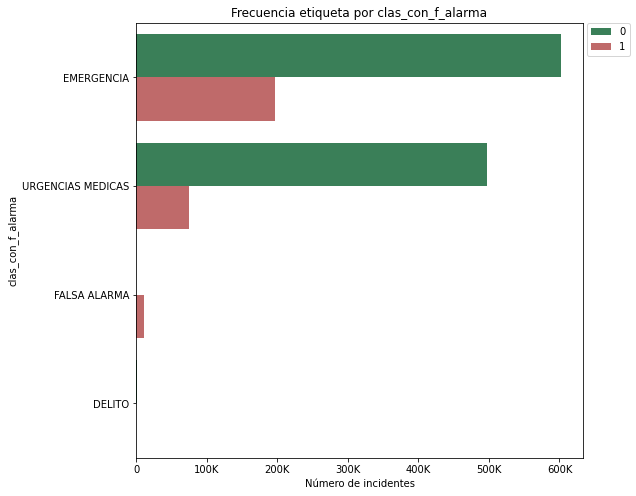

In [300]:
plt.figure(figsize = (8,8)) 
ax = sns.barplot(y = "clas_con_f_alarma", 
                 x = "size", 
                 data = clas_label, 
                 hue = "label", 
                 order = clas_total_orden,
                 palette = label_colors)
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter_i))
ax.set(title = 'Frecuencia etiqueta por clas_con_f_alarma', xlabel = 'Número de incidentes', ylabel = 'clas_con_f_alarma')
ax.legend(bbox_to_anchor = (1.01, 1), loc = 'upper left', borderaxespad = 0)
plt.show()

## Comparando misma delegación de inicio y cierre

In [301]:
df["misma_del"] = np.where(df["delegacion_inicio"] == df["delegacion_cierre"], True, False)

In [302]:
comparacion_del = pd.DataFrame(df['misma_del'].value_counts())
comparacion_del = comparacion_del.rename(columns = {'misma_del':'counts'}, index = {True:'Sí', False:'No'})
comparacion_del

,counts
Sí,1339316
No,43822


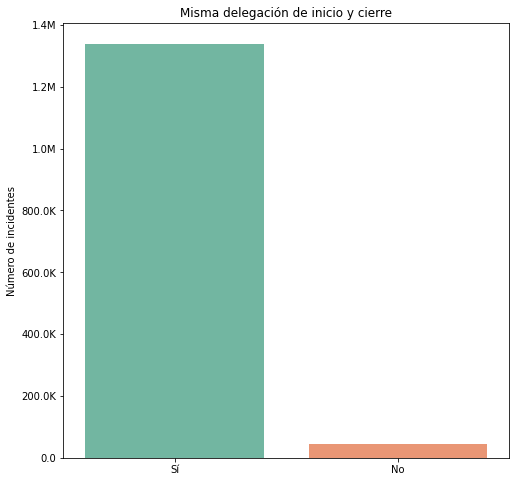

In [303]:
plt.figure(figsize = (8,8))
ax = sns.barplot(x = comparacion_del.index, 
                 y = 'counts', 
                 data = comparacion_del,
                 palette = "Set2")
ax.set(title = 'Misma delegación de inicio y cierre', ylabel = 'Número de incidentes')
ax.yaxis.set_major_formatter(FuncFormatter(number_formatter_f))
plt.show()

In [304]:
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [305]:
mapa_cdmx = gpd.read_file('/Users/cecy/Documents/MCD/IDS/Proyecto_1/df_municipio.shp')

In [306]:
geometry = [Point(xy) for xy in zip(df["longitud"], df["latitud"])]   
geo_df = gpd.GeoDataFrame(df, geometry = geometry) 

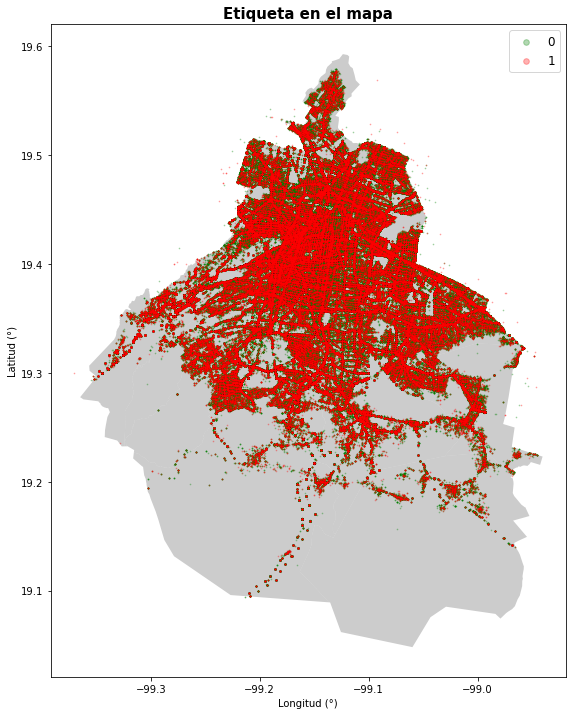

In [307]:
fig,ax = plt.subplots(figsize = (12,12))
mapa_cdmx.plot(ax = ax, alpha = 0.4, color = "grey")
geo_df[geo_df['label']==0].plot(ax=ax, markersize=0.5, color="green", alpha=0.3, label="0")
geo_df[geo_df['label']==1].plot(ax=ax, markersize=0.5, color="red", alpha=0.3, label="1")
plt.legend(prop = {'size':12}, markerscale = 8)
plt.title("Etiqueta en el mapa", fontweight = "bold", fontsize = "15")
plt.xlabel("Longitud (°)")
plt.ylabel("Latitud (°)")
plt.show()

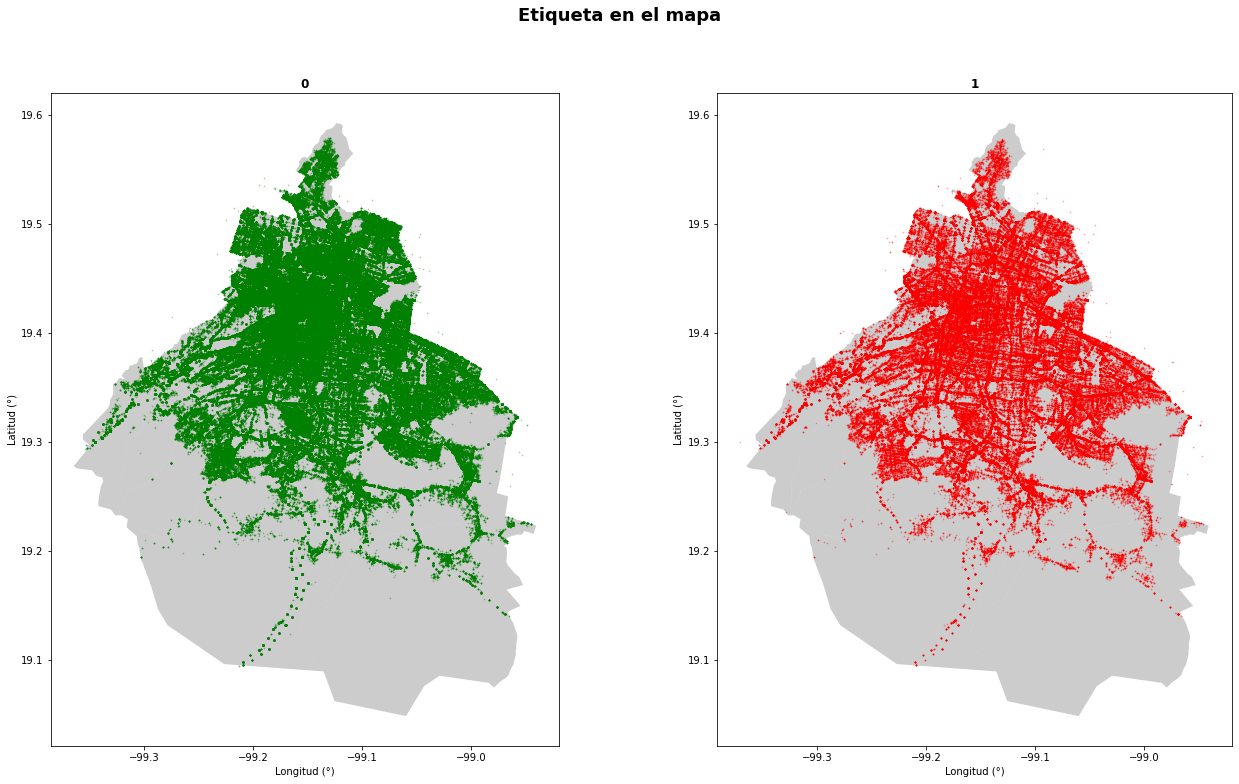

In [308]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,12))

mapa_cdmx.plot(ax=axes[0], alpha = 0.4, color = "grey")
geo_df[geo_df['label']==0].plot(ax=axes[0], markersize=0.5, color="green", alpha=0.3)
axes[0].set_title('0', fontweight = "bold")
axes[0].set_xlabel("Longitud (°)")
axes[0].set_ylabel("Latitud (°)")

mapa_cdmx.plot(ax=axes[1], alpha = 0.4, color = "grey")
geo_df[geo_df['label']==1].plot(ax=axes[1], markersize=0.5, color="red", alpha=0.3)
axes[1].set_title('1', fontweight = "bold")
axes[1].set_xlabel("Longitud (°)")
axes[1].set_ylabel("Latitud (°)")

fig.suptitle("Etiqueta en el mapa", fontweight = "bold", fontsize = 18)
plt.show()

## Tipo de entrada

In [309]:
tipo_entrada_total = pd.DataFrame(df['tipo_entrada'].value_counts())
tipo_entrada_total = tipo_entrada_total.rename(columns = {'tipo_entrada':'counts'})
tipo_entrada_label = df.groupby(['label','tipo_entrada'], as_index = False).size()

In [310]:
tipo_entrada_orden = ['LLAMADA DEL 911', 'LLAMADA DEL 066', 'BOTÓN DE AUXILIO', 'RADIO',
       'LLAMADA APP911', 'ZELLO', 'REDES', 'CÁMARA', 'APLICATIVOS']

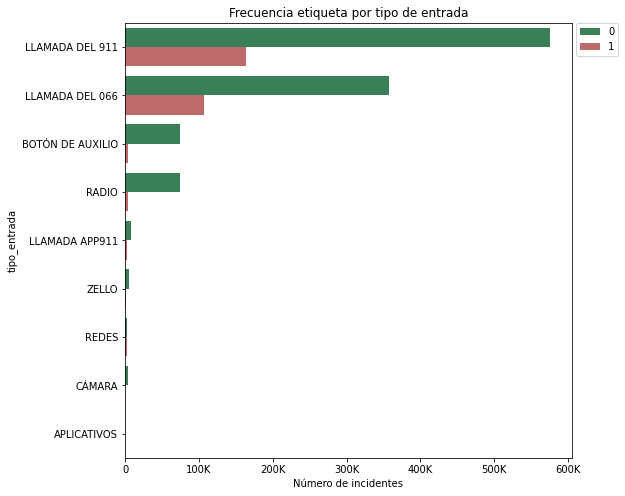

In [311]:
plt.figure(figsize = (8,8)) 
ax = sns.barplot(y = "tipo_entrada", 
                 x = "size", 
                 data = tipo_entrada_label, 
                 hue = "label", 
                 order = tipo_entrada_orden,
                 palette = label_colors)
ax.xaxis.set_major_formatter(FuncFormatter(number_formatter_i))
ax.set(title = 'Frecuencia etiqueta por tipo de entrada', xlabel = 'Número de incidentes', ylabel = 'tipo_entrada')
ax.legend(bbox_to_anchor = (1.01, 1), loc = 'upper left', borderaxespad = 0)
plt.show()

## Analizando fechas

In [312]:
fechas_raras = df[['folio', 'fecha_creacion', 'fecha_cierre']].copy()

In [313]:
fechas_raras['fecha_creacion'] = fechas_raras['fecha_creacion'].astype(str)
fechas_raras['fecha_cierre'] = fechas_raras['fecha_cierre'].astype(str)

In [314]:
folio_fecha = []
creacion = []
cierre = []

for i in range(0,len(fechas_raras["folio"])):
    folio_fecha.append(fechas_raras["folio"][i][3:9])
    creacion.append(fechas_raras["fecha_creacion"][i][2:4]+fechas_raras["fecha_creacion"][i][5:7]+fechas_raras["fecha_creacion"][i][8:10])
    cierre.append(fechas_raras["fecha_cierre"][i][2:4]+fechas_raras["fecha_cierre"][i][5:7]+fechas_raras["fecha_cierre"][i][8:10])

In [315]:
fechas_raras["folio_fecha"] = folio_fecha
fechas_raras["creacion"] = creacion
fechas_raras["cierre"] = cierre

In [316]:
fechas_raras.head()

,folio,fecha_creacion,fecha_cierre,folio_fecha,creacion,cierre
0,GA/160123/05714,2016-01-23,2016-01-24,160123,160123,160124
1,AO/160123/05826,2016-01-23,2016-01-24,160123,160123,160124
2,C4/160124/02187,2016-01-24,2016-01-24,160124,160124,160124
3,C4/160124/05723,2016-01-24,2016-01-24,160124,160124,160124
4,C4/160124/01334,2016-01-24,2016-01-24,160124,160124,160124


In [317]:
fechas_raras["Distintas"] = (fechas_raras["folio_fecha"] != fechas_raras["creacion"]) & (fechas_raras["folio_fecha"] != fechas_raras["cierre"])

In [318]:
fechas_raras["Distintas"].value_counts()

False    1383049
True          89
Name: Distintas, dtype: int64

In [319]:
fechas_raras[(fechas_raras.folio_fecha != fechas_raras.creacion) & (fechas_raras.folio_fecha != fechas_raras.cierre)]

,folio,fecha_creacion,fecha_cierre,folio_fecha,creacion,cierre,Distintas
18206,C5/180331/10862,2018-04-01,2018-04-01,180331,180401,180401,True
18246,C5/180331/10884,2018-04-01,2018-04-01,180331,180401,180401,True
86047,C5/170401/10006,2017-04-02,2017-04-02,170401,170402,170402,True
86068,AO/170401/10098,2017-04-02,2017-04-02,170401,170402,170402,True
86072,C5/170401/10310,2017-04-02,2017-04-02,170401,170402,170402,True
...,...,...,...,...,...,...,...
1283563,C5/180403/02466,2018-04-03,2018-04-03,180331,180401,180401,True
1295366,C5/200409/05368,2020-04-09,2020-04-09,200404,200405,200405,True
1295367,C5/200409/07424,2020-04-09,2020-04-09,200404,200405,200405,True
1295377,C5/200409/02182,2020-04-09,2020-04-09,200404,200405,200405,True
